In [100]:
%reload_ext autoreload
%autoreload 2

import numpy as np

import warnings
import torch
import pickle
import matplotlib.pyplot as plt

from Probe import get_pdata, probe_shapelet
import utils
from utils.constants import xai_names
from utils.visualization import plot_multiple_images_with_attribution
from utils.shapelet import get_distances_info_gain
from utils.model_utils import get_gradient_from_layers
from utils.insert_shapelet import get_gt_attr
warnings.filterwarnings("ignore")

In [101]:
device = 'cuda' if torch.cuda.is_available else 'cpu'

In [105]:
from tsai.models.RNN import RNN

model_path = 'models/simu3/'
model = RNN(c_in=1, c_out=2)
state_dict = torch.load(f'{model_path}/weight.pt',map_location='cuda:1')
model.load_state_dict(state_dict)
model.eval()

with open(f'models/simu3/data.pkl', 'rb') as f:
    data = pickle.load(f)
data.keys()
train_x, test_x, train_y, test_y = data['train_x'], data['test_x'], data['train_y'], data['test_y']
test_preds = np.load('models/simu3/test_preds.npy')
test_y = np.argmax(test_y, axis=1)
train_y = np.argmax(train_y, axis=1)

# instance_length = train_x.shape[-1]

# with open(f'shapelets/GunPoint/RSTF.pkl', 'rb') as f:
#     ST_attribution = pickle.load(f)
# # pick the first Shapelet
# info_gain, shapelet_length, start_pos, dimension, inst_index, shapelet_class, z_norm_shapelet = ST_attribution.shapelets[0]

In [106]:
model.to(device)
train_x_pred = model(torch.from_numpy(train_x).float().to(device)).detach().cpu().numpy()

In [ ]:
xai_names

IntegratedGradients


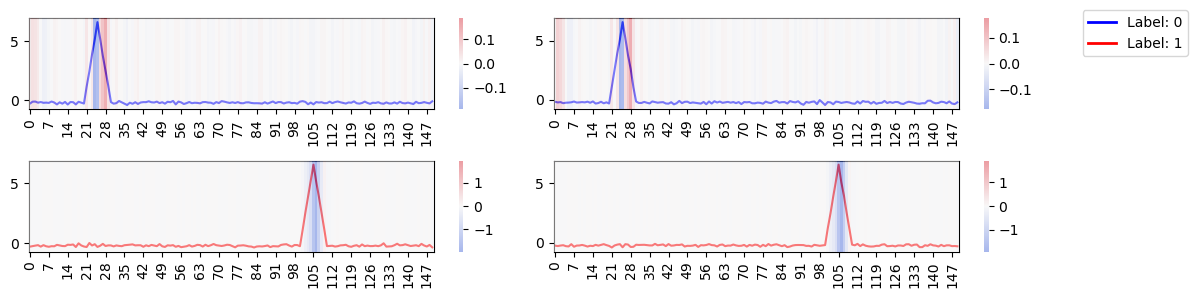

In [109]:
for xai_name in ['IntegratedGradients']:
    print(xai_name)
    model.train()
    attr_gp, _= get_gt_attr(model,train_x,None,None,
                            save_dir=f'attributions/simu3/{xai_name}/exp.pkl',
                            xai_name=xai_name,target_class=0)


    # with open(f'attributions/simu2/{xai_name}/train_exp.pkl', 'rb') as f:
    #     attr = pickle.load(f)
    # attr_gp = attr['attributions']
    # for i in range(2):
        # plot_multiple_images_with_attribution(train_x[0+i*25:25+i*25], train_y[0+i*25:25+i*25], 2, figsize=(12,3),
        #                               use_attribution=True,
        #                               attributions=attr_gp[0+i*25:25+i*25],
        #                               normalize_attribution=True,
        #                               save_path=None,
        #                               test_y = train_y[0+i*25:25+i*25],
        #                              )
    indices = [0, 24, 26, 31]
    plot_multiple_images_with_attribution(train_x[indices], train_y[indices], len(indices), figsize=(12,3),
                          use_attribution=True,
                          attributions=attr_gp[indices],
                          normalize_attribution=True,
                          save_path=None,
                          test_y = train_y[indices],
                         )

In [110]:
from pyts.transformation import ShapeletTransform
st = ShapeletTransform(window_sizes=[11],
                       random_state=42, sort=True)
X_new = st.fit_transform(train_x.reshape(train_x.shape[0],train_x.shape[-1]), train_y)

# Visualize the four most discriminative shapelets


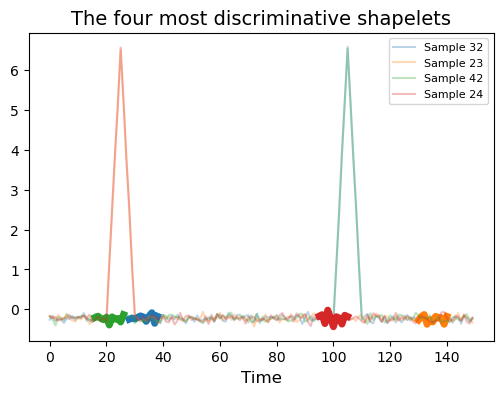

In [111]:
plt.figure(figsize=(6, 4))
for i, index in enumerate(st.indices_[:4]):
    idx, start, end = index
    plt.plot(train_x.reshape(train_x.shape[0],train_x.shape[-1])[idx], color='C{}'.format(i),
             label='Sample {}'.format(idx),alpha=0.3)
    plt.plot(np.arange(start, end), train_x.reshape(train_x.shape[0],train_x.shape[-1])[idx, start:end],
             lw=5, color='C{}'.format(i))

plt.xlabel('Time', fontsize=12)
plt.title('The four most discriminative shapelets', fontsize=14)
plt.legend(loc='best', fontsize=8)
plt.show()

In [ ]:
plt.figure(figsize=(24,3))
plt.plot(attr_gp[0])
plt.plot(train_x[0].flatten())
plt.axvline(x=9, color='r', linestyle='--', linewidth=2)
plt.axvline(x=30, color='r', linestyle='--', linewidth=2)

plt.axvline(x=401, color='r', linestyle='--', linewidth=2)
plt.axvline(x=422, color='r', linestyle='--', linewidth=2)

In [ ]:
shapelet = train_x[0,:,401:422].flatten()
# shapelet = utils.z_norm_process_shapelet(shapelet)
plt.plot(shapelet)
instance_length = train_x.shape[-1]
start_pos=401
print(min(shapelet),max(shapelet))

In [ ]:
shapelet = np.sin(np.linspace(0,1*np.pi,21))*12-6#np.random.normal(0,0.05,21) 
plt.plot(shapelet)

In [ ]:
pdata = get_pdata(shapelet=shapelet, selected_datasets=utils.selected_uni, inst_length=instance_length, 
                   num_shapelet=1, is_add=False, repeat_max=100,
                       is_z_norm=True, save_dir='probe/simu_implet_random_scaled')

In [ ]:
with open('probe/simu_implet_random_scaled/pdata.pkl','rb') as f:
    pdata = pickle.load(f)

In [ ]:
plt.plot(pdata['pdata_ws'][0].flatten(),label='with shapelet')
plt.plot(pdata['pdata_wos'][0].flatten(),label='without shapelet')

In [ ]:
pdata = np.concatenate((pdata['pdata_ws'],pdata['pdata_wos']), axis=0)

In [ ]:
start_pos=0
shapelet = np.sin(np.linspace(0,1*np.pi,21))*12-6#np.random.normal(0,0.05,21) 

In [ ]:
dataset_s_label = np.array([1]*2000)
p_data_labels = np.array([0]*1680 +[1]*1680)
shapelet_labels = [dataset_s_label,p_data_labels]

results = probe_shapelet(dataset=train_x, labels=train_y, pdata=pdata, model=model, save_path='probe/simu_implet_random_scaled',
                         shapelet=shapelet, pos=start_pos, device='cuda:1',shapelet_labels=shapelet_labels)

In [ ]:
probe_coef = results['classifier'].coef_.flatten()

In [ ]:
import torch
import torch.nn as nn

# Assuming `fcn_model` is your pretrained tsai FCN model
class FCNWithSoftmax(nn.Module):
    def __init__(self, fcn_model):
        super(FCNWithSoftmax, self).__init__()
        self.fcn_model = fcn_model
        self.softmax = nn.Softmax(dim=1)  # Apply softmax across the class dimension

    def forward(self, x):
        logits = self.fcn_model(x)  # Get the logits from the original model
        probabilities = self.softmax(logits)  # Apply softmax to get probabilities
        return probabilities

# Load your trained FCN model
# fcn_model = load_your_trained_fcn_model()

# Wrap the FCN model with the softmax layer
fcn_with_softmax = FCNWithSoftmax(model)

In [ ]:
fcn_with_softmax


In [ ]:
plt.hist(fcn_with_softmax.fcn_model.fc.weight[0].detach().cpu().numpy().flatten(),bins=100)
plt.show()
plt.hist(fcn_with_softmax.fcn_model.fc.weight[1].detach().cpu().numpy().flatten(),bins=100)
plt.show()

In [ ]:
#get_gradient_from_layers(model, hook_block, data, target_class: Union[int, Container], device='cuda')
from utils.model_utils import get_gradient_from_layers
c0_grad = get_gradient_from_layers(fcn_with_softmax, fcn_with_softmax.fcn_model.gap.gap, train_x[995:1005],0)
c0_grad

In [ ]:
probe_coef

In [ ]:
c0_grad / np.linalg.norm(c0_grad, axis=1)[:, np.newaxis]

In [ ]:
c0_grad / np.linalg.norm(c0_grad, axis=1)

In [ ]:
scores = c0_grad @ probe_coef / np.linalg.norm(c0_grad, axis=1) / np.linalg.norm(probe_coef)

In [ ]:
scores

In [ ]:
with open('probe/simu_implet_random_scaled/probe_latent_label.pkl', 'rb') as f:
    probe_latent_label = pickle.load(f)
dataset_s_distances = probe_latent_label['dataset_s_distances']
pdata_s_distances = probe_latent_label['pdata_s_distances']
# best_threshold = probe_latent_label['best_threshold']
dataset_s_label = probe_latent_label['dataset_s_label']
pdata_s_label = probe_latent_label['pdata_s_label']
dataset_latent = probe_latent_label['dataset_latent']
pdata_latent = probe_latent_label['pdata_latent']

In [ ]:
print(np.count_nonzero([i==1 for i in dataset_s_label]))
print(np.count_nonzero([i==0 for i in dataset_s_label]))

In [ ]:
print(np.count_nonzero([i==1 for i in pdata_s_label]))
print(np.count_nonzero([i==0 for i in pdata_s_label]))

In [ ]:
with open('probe/simu_implet_random_scaled/results.pkl', 'rb') as f:
    results = pickle.load(f)
# pdata_s_pred = results['pdata_s_pred']
dataset_s_pred = results['dataset_s_pred']
print(np.count_nonzero([i==1 for i in dataset_s_pred]))
print(np.count_nonzero([i==0 for i in dataset_s_pred]))
# print(np.count_nonzero([i==1 for i in pdata_s_pred]))
# print(np.count_nonzero([i==0 for i in pdata_s_pred]))

In [ ]:
len(dataset_s_label)

In [ ]:
label = np.zeros(len(pdata_s_label)+len(dataset_s_label),dtype=np.uint8)
for i in range(len(pdata_s_label)+len(dataset_s_label)):
    if i<3360 and pdata_s_label[i]==0:
        label[i] = 0
    elif i<3360 and pdata_s_label[i]==1:
        label[i] = 1 
    elif i>=3360 and dataset_s_label[i-3360]==0:
        label[i] = 2
    elif i>=3360 and dataset_s_label[i-3360]==1:
        label[i] = 3

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(perplexity=5)
latent_vis = tsne.fit_transform(np.concatenate((pdata_latent,dataset_latent)))

In [ ]:
plt.scatter(latent_vis[label == 0, 0], latent_vis[label == 0, 1], label='fake, w/ random shapelet', s=5)
plt.scatter(latent_vis[label == 1, 0], latent_vis[label == 1, 1], label='fake, w/o random shapelet', s=5)
plt.scatter(latent_vis[label == 2, 0], latent_vis[label == 2, 1], label='simu, w/', s=5, color=plt.get_cmap('tab10')(2))
plt.scatter(latent_vis[label == 3, 0], latent_vis[label == 3, 1], label='simu, w/o', s=5, color=plt.get_cmap('tab10')(3))

plt.legend()
plt.savefig('probe/simu_implet_random_scaled/tsne.png')

In [ ]:
probe_shapelet(dataset=train_x, labels=train_y, pdata=test_x, model=model, 
                         shapelet=shapelet, pos=start_pos, device='cuda:1')